In [2]:
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock, StochasticSequential
import numpy as onp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import celluloid
npx.set_np()

In [3]:
class gaussian_mixture(mgp.Distribution):
    def __init__(self, pi, loc, scale):
        self.categorical = mgp.OneHotCategorical(num_events=2, prob=pi)
        self.normal = mgp.Normal(loc, scale)
        
    def sample(self, size=None):
        return (self.categorical.sample(size) * self.normal.sample_n(size)).sum(1)
    
    def pdf(self, value):
        value = np.repeat(value[..., None], 2, -1)
        component_wise_density = np.exp(self.normal.log_prob(value))
        return (self.categorical.prob * component_wise_density).sum(1)
    
    def log_prob(self, value):
        return np.log(self.pdf(value))

1-D mixture of Gaussian with $2$ components.

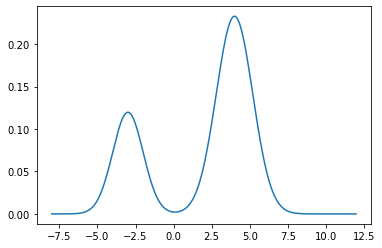

In [98]:
pi = np.array([0.3, 0.7])
loc_mob = np.array([-3.0, 4.0])
scale_mob = np.array([1.0, 1.2])
mob = gaussian_mixture(pi, loc_mob, scale_mob)
x = np.arange(-8.0, 12.0, 0.01)
plt.plot(x.asnumpy(), mob.pdf(x).asnumpy())

## Forward/Backward KL (TODO: Fix notation)

Objective for minimizing forward KL-divergence:
$$
\begin{align*}
D_{KL}(P \| Q) &=  \mathbb{E}_{x \sim P}[-\log Q_\theta(X)] - \mathcal{H}(P(X))\\
&=  \mathbb{E}_{x \sim P}[-\log Q_\theta(X)]\\
\end{align*}
$$

In [5]:
def forward_kl_objective(q, p, sample_size=(500,)):
    """
    q: Univariate Gaussian
    p: Mixture of Gaussian
    """
    p_samples = p.sample(sample_size)
    return -q.log_prob(p_samples).mean()

Objective for minimizing reverse KL-divergence
$$
\begin{align*}
D_{KL}(Q \| P) &= \mathbb{E}_{x \sim Q_\theta}[-\log P(X)] - \mathcal{H}(Q_\theta(X))\\
&=  -(\mathbb{E}_{x \sim Q_\theta}[\log P(X)] + \mathcal{H}(Q_{\theta}(X)))
\end{align*}
$$

In [93]:
def reverse_kl_objective(q, p, sample_size=(500,)):
    """
    q: Univariate Gaussian
    p: Mixture of Gaussian
    """
    q_samples = q.sample(sample_size)
    entropy = q.entropy()
    log_px = p.log_prob(q_samples)
    return -(log_px.mean() + entropy)

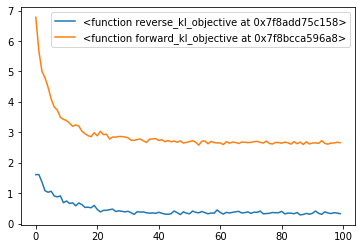

In [106]:
num_iter, lr= 100, 0.1
def gd(params, lr):
    for t in params:
        t -= lr * t.grad

def train(objective, num_iter, lr, initial_loc=2.0):
    loc_q = np.array([initial_loc])
    log_scale_q = np.array([0.0])
    loc_q.attach_grad()
    log_scale_q.attach_grad()   
    loss_train = []
    loc_train = []
    scale_train = []
    for iter in range(num_iter):
        loc_train.append(loc_q.copy())
        scale_train.append(log_scale_q.copy())
        with autograd.record():
            q = mgp.Normal(loc_q, np.exp(log_scale_q))
            loss = objective(q, mob)
        loss.backward()
        gd([loc_q, log_scale_q], lr)
        loss_train.append(loss.asnumpy())
    plt.plot(loss_train, label=str(objective))
    return loc_train, scale_train
loc_r, scale_r = train(reverse_kl_objective, num_iter, 0.1)
loc_f, scale_f = train(forward_kl_objective, num_iter, 0.01)
plt.legend()

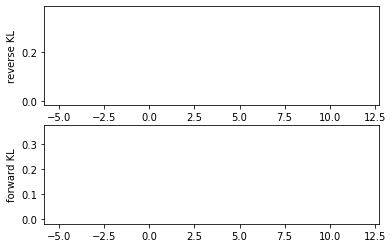

In [107]:
from celluloid import Camera

def plot_gaussian(p, ax, low=-5.0, high=12.0):
    x = np.arange(low, high, 0.1)
    px = np.exp(p.log_prob(x))
    qx = mob.pdf(x)
    ax.plot(x.asnumpy(), qx, c='g')
    ax.plot(x.asnumpy(), px.asnumpy(), c='r')
    
fig, axes = plt.subplots(2)
cam = Camera(fig)
for i in list(range(num_iter))[::2]:
    normal_r = mgp.Normal(loc_r[i - 1], np.exp(scale_r[i - 1]))
    normal_f = mgp.Normal(loc_f[i - 1], np.exp(scale_f[i - 1]))
    plot_gaussian(normal_r, axes[0])
    axes[0].set_ylabel('reverse KL')
    plot_gaussian(normal_f, axes[1])
    axes[1].set_ylabel('forward KL')
    cam.snap()
animation = cam.animate()
HTML(animation.to_html5_video())